# BERT4Rec: Bidirectional Transformer for Sequential Recommendation

This notebook implements BERT4Rec, which applies the BERT architecture to sequential recommendation.

**Key Features:**
- Bidirectional self-attention (unlike unidirectional LSTM)
- Masked Item Prediction (Cloze task) for training
- Positional embeddings to encode sequence order

**Reference:** Sun et al., "BERT4Rec: Sequential Recommendation with Bidirectional Encoder Representations from Transformer"

## 1. Setup and Configuration

In [1]:
import os
import sys
import platform
import numpy as np
import pandas as pd
import pickle
import math
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

# Enable MPS fallback only on macOS (Apple Silicon)
if platform.system() == 'Darwin':
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
    print("macOS detected: Enabled MPS fallback for unsupported ops")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Check device
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using Apple Silicon GPU (MPS)')
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using NVIDIA GPU (CUDA)')
else:
    device = torch.device('cpu')
    print('Using CPU')

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

macOS detected: Enabled MPS fallback for unsupported ops
Using Apple Silicon GPU (MPS)


In [2]:
CONFIG = {
    # Paths
    'data_dir': '../data/processed',
    'model_dir': '../models',
    'results_dir': '../results',
    
    # Model hyperparameters
    'embedding_dim': 64,
    'n_heads': 2,
    'n_layers': 2,
    'dropout': 0.2,
    'max_seq_len': 50,
    
    # Training
    'learning_rate': 0.001,
    'batch_size': 128,
    'n_epochs': 50,
    'mask_prob': 0.2,  # Probability of masking items
    
    # Evaluation
    'top_k': [5, 10, 20],
    'eval_every': 5,
}

Path(CONFIG['model_dir']).mkdir(parents=True, exist_ok=True)
Path(CONFIG['results_dir']).mkdir(parents=True, exist_ok=True)

print("Configuration:")
for k, v in CONFIG.items():
    if not k.endswith('_dir'):
        print(f"  {k}: {v}")

Configuration:
  embedding_dim: 64
  n_heads: 2
  n_layers: 2
  dropout: 0.2
  max_seq_len: 50
  learning_rate: 0.001
  batch_size: 128
  n_epochs: 50
  mask_prob: 0.2
  top_k: [5, 10, 20]
  eval_every: 5


## 2. Load Sequential Data

In [3]:
# Load sequences
with open(os.path.join(CONFIG['data_dir'], 'sequences.pkl'), 'rb') as f:
    seq_data = pickle.load(f)

user_sequences = seq_data['user_sequences']
val_targets = seq_data['val_targets']
test_targets = seq_data['test_targets']
n_users = seq_data['n_users']
n_items = seq_data['n_items']

# Special tokens
PAD_TOKEN = 0
MASK_TOKEN = n_items + 1  # Special mask token

print(f"Data loaded:")
print(f"  Users: {n_users:,}")
print(f"  Items: {n_items:,}")
print(f"  PAD token: {PAD_TOKEN}")
print(f"  MASK token: {MASK_TOKEN}")

Data loaded:
  Users: 357
  Items: 479
  PAD token: 0
  MASK token: 480


## 3. BERT4Rec Dataset with Masking

In [4]:
class BERT4RecDataset(Dataset):
    """
    Dataset for BERT4Rec with masked item prediction.
    
    For training: randomly mask items and predict them (Cloze task)
    For inference: mask the last position and predict next item
    """
    def __init__(self, user_sequences, max_seq_len, n_items, mask_token, mask_prob=0.2, mode='train'):
        self.max_seq_len = max_seq_len
        self.n_items = n_items
        self.mask_token = mask_token
        self.mask_prob = mask_prob
        self.mode = mode
        
        # Create samples
        self.samples = []
        for user_id, items in user_sequences.items():
            if len(items) < 2:
                continue
            # Truncate/pad to max_seq_len
            seq = items[-max_seq_len:] if len(items) >= max_seq_len else items
            self.samples.append((user_id, seq))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        user_id, seq = self.samples[idx]
        
        # Shift items by 1 (0 is padding)
        tokens = [item + 1 for item in seq]
        
        # Pad sequence
        seq_len = len(tokens)
        padding_len = self.max_seq_len - seq_len
        tokens = [0] * padding_len + tokens  # Left padding
        
        if self.mode == 'train':
            # Create masked sequence and labels
            masked_tokens = tokens.copy()
            labels = [0] * len(tokens)  # 0 means no prediction needed
            
            # Mask random items (only non-padding)
            for i in range(padding_len, len(tokens)):
                if np.random.random() < self.mask_prob:
                    labels[i] = masked_tokens[i]  # Original token as label
                    masked_tokens[i] = self.mask_token  # Replace with mask
            
            return {
                'input_ids': torch.tensor(masked_tokens, dtype=torch.long),
                'labels': torch.tensor(labels, dtype=torch.long),
                'user_id': user_id
            }
        else:
            # For evaluation: mask last position
            return {
                'input_ids': torch.tensor(tokens, dtype=torch.long),
                'seq_len': seq_len,
                'user_id': user_id
            }

# Create datasets
train_dataset = BERT4RecDataset(
    user_sequences, CONFIG['max_seq_len'], n_items, MASK_TOKEN,
    mask_prob=CONFIG['mask_prob'], mode='train'
)
eval_dataset = BERT4RecDataset(
    user_sequences, CONFIG['max_seq_len'], n_items, MASK_TOKEN,
    mode='eval'
)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0)
eval_loader = DataLoader(eval_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)

print(f"Training samples: {len(train_dataset):,}")
print(f"Evaluation samples: {len(eval_dataset):,}")

Training samples: 357
Evaluation samples: 357


## 4. BERT4Rec Model

In [5]:
class BERT4Rec(nn.Module):
    """
    BERT4Rec: Bidirectional Transformer for Sequential Recommendation.
    
    Architecture:
    1. Item + Position embeddings
    2. Transformer Encoder layers
    3. Output projection to item space
    """
    def __init__(self, n_items, embedding_dim, n_heads, n_layers, max_seq_len, dropout=0.1):
        super().__init__()
        
        self.n_items = n_items
        self.embedding_dim = embedding_dim
        
        # Embeddings (n_items + 2: padding=0, items=1..n_items, mask=n_items+1)
        self.item_embedding = nn.Embedding(n_items + 2, embedding_dim, padding_idx=0)
        self.position_embedding = nn.Embedding(max_seq_len, embedding_dim)
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=n_heads,
            dim_feedforward=embedding_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Layer norm and dropout
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)
        
        # Output projection
        self.output = nn.Linear(embedding_dim, n_items + 1)  # +1 for padding
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.normal_(self.item_embedding.weight, std=0.02)
        nn.init.normal_(self.position_embedding.weight, std=0.02)
        
    def forward(self, input_ids, return_all=False):
        """
        Args:
            input_ids: (batch, seq_len) - tokenized sequence
            return_all: If True, return logits for all positions
            
        Returns:
            logits: (batch, seq_len, n_items+1) or (batch, n_items+1)
        """
        batch_size, seq_len = input_ids.shape
        
        # Create position IDs
        position_ids = torch.arange(seq_len, device=input_ids.device).unsqueeze(0).expand(batch_size, -1)
        
        # Embeddings
        item_emb = self.item_embedding(input_ids)
        pos_emb = self.position_embedding(position_ids)
        hidden = self.dropout(self.layer_norm(item_emb + pos_emb))
        
        # Create attention mask for causal attention (optional, can skip for bidirectional)
        # For MPS compatibility, we skip src_key_padding_mask and handle padding in embeddings
        
        # Transformer (no explicit mask - padding handled by embedding)
        hidden = self.transformer(hidden)
        
        # Output logits
        logits = self.output(hidden)
        
        if return_all:
            return logits
        else:
            # Return logits for last position (next item prediction)
            return logits[:, -1, :]

# Initialize model
model = BERT4Rec(
    n_items=n_items,
    embedding_dim=CONFIG['embedding_dim'],
    n_heads=CONFIG['n_heads'],
    n_layers=CONFIG['n_layers'],
    max_seq_len=CONFIG['max_seq_len'],
    dropout=CONFIG['dropout']
)
model = model.to(device)

print("Model Architecture:")
print(f"  Embedding dim: {CONFIG['embedding_dim']}")
print(f"  Attention heads: {CONFIG['n_heads']}")
print(f"  Transformer layers: {CONFIG['n_layers']}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Model Architecture:
  Embedding dim: 64
  Attention heads: 2
  Transformer layers: 2
  Total parameters: 165,280


## 5. Loss and Optimizer

In [6]:
# Cross-entropy loss, ignoring padding (label=0)
criterion = nn.CrossEntropyLoss(ignore_index=0)

optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

print("Loss: CrossEntropyLoss (masked language modeling)")
print(f"Optimizer: Adam (lr={CONFIG['learning_rate']})")

Loss: CrossEntropyLoss (masked language modeling)
Optimizer: Adam (lr=0.001)


## 6. Evaluation Metrics

In [7]:
def evaluate_model(model, user_sequences, targets, max_seq_len, n_items, k_values=[5, 10, 20], batch_size=128):
    """
    Evaluate BERT4Rec on next-item prediction.
    """
    model.eval()
    
    valid_users = [u for u in targets.keys() if u in user_sequences and len(user_sequences[u]) >= 1]
    
    metrics = {f'Precision@{k}': [] for k in k_values}
    metrics.update({f'Recall@{k}': [] for k in k_values})
    metrics.update({f'NDCG@{k}': [] for k in k_values})
    metrics.update({f'HR@{k}': [] for k in k_values})
    
    with torch.no_grad():
        for i in range(0, len(valid_users), batch_size):
            batch_users = valid_users[i:i+batch_size]
            
            # Prepare sequences
            input_ids_list = []
            batch_targets = []
            seen_items = []
            
            for user in batch_users:
                seq = user_sequences[user][-max_seq_len:]
                tokens = [item + 1 for item in seq]  # Shift by 1
                
                # Pad sequence (left padding)
                padding_len = max_seq_len - len(tokens)
                tokens = [0] * padding_len + tokens
                
                input_ids_list.append(tokens)
                batch_targets.append(targets[user])
                seen_items.append(set(seq))
            
            # Convert to tensor
            input_ids = torch.tensor(input_ids_list, dtype=torch.long, device=device)
            
            # Get scores for last position
            scores = model(input_ids, return_all=False).cpu().numpy()  # (batch, n_items+1)
            scores = scores[:, 1:]  # Remove padding column, now (batch, n_items)
            
            # Mask seen items
            for idx, seen in enumerate(seen_items):
                scores[idx, list(seen)] = -np.inf
            
            # Get top-K
            max_k = max(k_values)
            top_items = np.argsort(-scores, axis=1)[:, :max_k]
            
            # Compute metrics
            for idx, target in enumerate(batch_targets):
                for k in k_values:
                    top_k = top_items[idx, :k]
                    hit = 1 if target in top_k else 0
                    
                    metrics[f'HR@{k}'].append(hit)
                    metrics[f'Precision@{k}'].append(hit / k)
                    metrics[f'Recall@{k}'].append(hit)
                    
                    if target in top_k:
                        rank = np.where(top_k == target)[0][0]
                        metrics[f'NDCG@{k}'].append(1.0 / np.log2(rank + 2))
                    else:
                        metrics[f'NDCG@{k}'].append(0.0)
    
    return {k: np.mean(v) for k, v in metrics.items()}

## 7. Training

In [8]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch with masked item prediction."""
    model.train()
    total_loss = 0
    
    for batch in tqdm(train_loader, desc='Training', leave=False):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward
        logits = model(input_ids, return_all=True)  # (batch, seq_len, n_items+1)
        
        # Compute loss only on masked positions
        logits_flat = logits.view(-1, logits.size(-1))  # (batch*seq_len, n_items+1)
        labels_flat = labels.view(-1)  # (batch*seq_len,)
        
        loss = criterion(logits_flat, labels_flat)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

In [9]:
# Training loop
print("Starting training...")
print("="*60)

history = {'loss': [], 'val_ndcg': []}
best_ndcg = 0
best_epoch = 0

for epoch in range(1, CONFIG['n_epochs'] + 1):
    loss = train_epoch(model, train_loader, criterion, optimizer, device)
    history['loss'].append(loss)
    
    if epoch % CONFIG['eval_every'] == 0 or epoch == 1:
        val_metrics = evaluate_model(
            model, user_sequences, val_targets, 
            CONFIG['max_seq_len'], n_items, CONFIG['top_k']
        )
        ndcg = val_metrics['NDCG@10']
        history['val_ndcg'].append(ndcg)
        
        print(f"Epoch {epoch:3d} | Loss: {loss:.4f} | NDCG@10: {ndcg:.4f} | HR@10: {val_metrics['HR@10']:.4f}")
        
        scheduler.step(ndcg)
        
        if ndcg > best_ndcg:
            best_ndcg = ndcg
            best_epoch = epoch
            torch.save(model.state_dict(), os.path.join(CONFIG['model_dir'], 'bert4rec_best.pt'))
    else:
        print(f"Epoch {epoch:3d} | Loss: {loss:.4f}")

print("="*60)
print(f"Training complete! Best NDCG@10: {best_ndcg:.4f} at epoch {best_epoch}")

Starting training...


Epoch   1 | Loss: 6.3432 | NDCG@10: 0.0008 | HR@10: 0.0028


Epoch   2 | Loss: 6.2973


Epoch   3 | Loss: 6.2489


Epoch   4 | Loss: 6.1809


Epoch   5 | Loss: 6.1735 | NDCG@10: 0.0026 | HR@10: 0.0084


Epoch   6 | Loss: 6.1255


Epoch   7 | Loss: 6.1033


Epoch   8 | Loss: 6.0833


Epoch   9 | Loss: 6.0948


Epoch  10 | Loss: 6.0232 | NDCG@10: 0.0059 | HR@10: 0.0112


Epoch  11 | Loss: 5.9697


Epoch  12 | Loss: 5.9766


Epoch  13 | Loss: 5.9252


Epoch  14 | Loss: 5.9349


Epoch  15 | Loss: 5.8588 | NDCG@10: 0.0076 | HR@10: 0.0112


Epoch  16 | Loss: 5.8294


Epoch  17 | Loss: 5.8172


Epoch  18 | Loss: 5.7215


Epoch  19 | Loss: 5.6710


Epoch  20 | Loss: 5.6848 | NDCG@10: 0.0063 | HR@10: 0.0140


Epoch  21 | Loss: 5.6367


Epoch  22 | Loss: 5.5838


Epoch  23 | Loss: 5.5582


Epoch  24 | Loss: 5.5540


Epoch  25 | Loss: 5.4995 | NDCG@10: 0.0072 | HR@10: 0.0196


Epoch  26 | Loss: 5.4399


Epoch  27 | Loss: 5.4481


Epoch  28 | Loss: 5.4438


Epoch  29 | Loss: 5.3100


Epoch  30 | Loss: 5.3283 | NDCG@10: 0.0074 | HR@10: 0.0196


Epoch  31 | Loss: 5.2680


Epoch  32 | Loss: 5.2572


Epoch  33 | Loss: 5.2397


Epoch  34 | Loss: 5.1546


Epoch  35 | Loss: 5.1567 | NDCG@10: 0.0050 | HR@10: 0.0140


Epoch  36 | Loss: 5.0985


Epoch  37 | Loss: 5.0969


Epoch  38 | Loss: 5.0232


Epoch  39 | Loss: 4.9797


Epoch  40 | Loss: 5.0076 | NDCG@10: 0.0040 | HR@10: 0.0112


Epoch  41 | Loss: 4.9616


Epoch  42 | Loss: 4.9071


Epoch  43 | Loss: 4.8752


Epoch  44 | Loss: 4.8734


Epoch  45 | Loss: 4.8493 | NDCG@10: 0.0030 | HR@10: 0.0084


Epoch  46 | Loss: 4.8356


Epoch  47 | Loss: 4.7718


Epoch  48 | Loss: 4.8207


Epoch  49 | Loss: 4.7954


Epoch  50 | Loss: 4.7810 | NDCG@10: 0.0039 | HR@10: 0.0112
Training complete! Best NDCG@10: 0.0076 at epoch 15


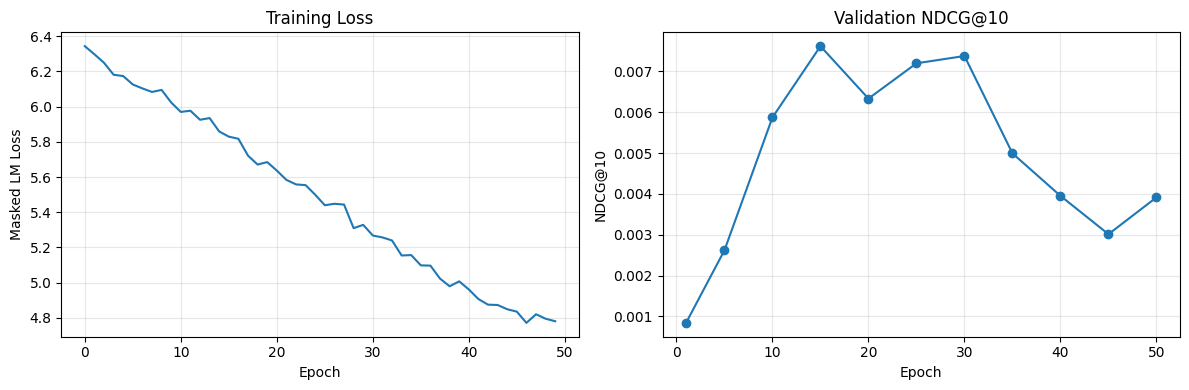

In [10]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['loss'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Masked LM Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

eval_epochs = [1] + list(range(CONFIG['eval_every'], CONFIG['n_epochs']+1, CONFIG['eval_every']))
eval_epochs = eval_epochs[:len(history['val_ndcg'])]
axes[1].plot(eval_epochs, history['val_ndcg'], marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('NDCG@10')
axes[1].set_title('Validation NDCG@10')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['results_dir'], 'bert4rec_training.png'), dpi=150)
plt.show()

## 8. Final Evaluation on Test Set

In [11]:
# Load best model
model.load_state_dict(torch.load(os.path.join(CONFIG['model_dir'], 'bert4rec_best.pt')))

# Evaluate on test set
test_metrics = evaluate_model(
    model, user_sequences, test_targets,
    CONFIG['max_seq_len'], n_items, CONFIG['top_k']
)

print("="*60)
print("FINAL TEST RESULTS - BERT4Rec")
print("="*60)
for metric, value in sorted(test_metrics.items()):
    print(f"  {metric}: {value:.4f}")

FINAL TEST RESULTS - BERT4Rec
  HR@10: 0.0168
  HR@20: 0.0280
  HR@5: 0.0112
  NDCG@10: 0.0086
  NDCG@20: 0.0115
  NDCG@5: 0.0070
  Precision@10: 0.0017
  Precision@20: 0.0014
  Precision@5: 0.0022
  Recall@10: 0.0168
  Recall@20: 0.0280
  Recall@5: 0.0112


## 9. Comparison with Baselines

In [12]:
# Load previous results
results_to_compare = {}

try:
    with open(os.path.join(CONFIG['results_dir'], 'mf_results.pkl'), 'rb') as f:
        results_to_compare['MF'] = pickle.load(f)['test_metrics']
except:
    pass

try:
    with open(os.path.join(CONFIG['results_dir'], 'lstm_results.pkl'), 'rb') as f:
        results_to_compare['LSTM'] = pickle.load(f)['test_metrics']
except:
    pass

results_to_compare['BERT4Rec'] = test_metrics

print("="*70)
print("MODEL COMPARISON")
print("="*70)

# Print header
models = list(results_to_compare.keys())
header = f"{'Metric':<15}" + "".join([f"{m:>12}" for m in models])
print(header)
print("-"*len(header))

# Print metrics
for metric in sorted(test_metrics.keys()):
    row = f"{metric:<15}"
    for model_name in models:
        val = results_to_compare[model_name].get(metric, 0)
        row += f"{val:>12.4f}"
    print(row)

MODEL COMPARISON
Metric                   MF        LSTM    BERT4Rec
---------------------------------------------------
HR@10                0.0084      0.0308      0.0168
HR@20                0.0224      0.0504      0.0280
HR@5                 0.0028      0.0112      0.0112
NDCG@10              0.0030      0.0137      0.0086
NDCG@20              0.0067      0.0184      0.0115
NDCG@5               0.0014      0.0075      0.0070
Precision@10         0.0008      0.0031      0.0017
Precision@20         0.0011      0.0025      0.0014
Precision@5          0.0006      0.0022      0.0022
Recall@10            0.0084      0.0308      0.0168
Recall@20            0.0224      0.0504      0.0280
Recall@5             0.0028      0.0112      0.0112


In [13]:
# Save results
results = {
    'model': 'BERT4Rec',
    'config': CONFIG,
    'best_epoch': best_epoch,
    'best_val_ndcg': best_ndcg,
    'test_metrics': test_metrics,
    'history': history
}

with open(os.path.join(CONFIG['results_dir'], 'bert4rec_results.pkl'), 'wb') as f:
    pickle.dump(results, f)

with open(os.path.join(CONFIG['results_dir'], 'bert4rec_results.txt'), 'w') as f:
    f.write("BERT4Rec Results\n")
    f.write("="*40 + "\n\n")
    f.write("Configuration:\n")
    for k, v in CONFIG.items():
        f.write(f"  {k}: {v}\n")
    f.write(f"\nBest Epoch: {best_epoch}\n")
    f.write(f"Best Validation NDCG@10: {best_ndcg:.4f}\n")
    f.write("\nTest Metrics:\n")
    for metric, value in sorted(test_metrics.items()):
        f.write(f"  {metric}: {value:.4f}\n")

print("Results saved!")

Results saved!


## Summary

BERT4Rec (Transformer-based) implemented and trained!

**Key Features:**
- Bidirectional self-attention captures complex dependencies
- Masked item prediction (Cloze task) for training
- Position embeddings encode sequence order

**Next Steps:**
- Implement LightGCN (Graph Neural Network)
- Final comparison of all models